<a href="https://colab.research.google.com/github/akash1331/inae-serb/blob/main/Text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from attention import AttentionLayer

In [3]:
import numpy as np
import pandas as pd
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv("train.csv")
data.head()

,FileName,Abstract,RHS
0,S0262885614000857,This paper introduces four classes of rotation invariant orthogonal moments by generalizing four existing moments that use harmonic functions in their radial kernels . Members of these classes sh...,We generalize polar harmonic transforms for pattern description recognition. The generalization maintains beneficial properties of existing transforms. The completeness of the corresponding basis ...
1,S0169260715300419,In this paper a MATLAB based graphical user interface software tool for general biomedical signal processing and analysis of functional neuroimaging data is introduced . Specifically electroencep...,Design of a MATLAB based GUI tool for general biomedical signal processing and analysis. EEG and ECG signals can be processed and analyzed by the designed tool. The easy to use and easy to learn i...
2,S0169260715003260,Background and objective A markerless low cost prototype has been developed for the determination of some spatio temporal parameters of human gait step length step width and cadence have been con...,A markerless low cost system for the estimation of some spatial temporal parameters of human gait. A system usable on not instrumented treadmill. A system characterized by a very high level of aut...
3,S0262885613001443,This paper presents an improved multiple instance learning tracker representing target with Distribution Fields and building a weighted geometric mean MIL classifier . Firstly we adopt DF layer a...,We adopt Distribution Field DF layer as feature instead of traditional Haar like one to robustly model the target. We derive an online weighted geometric mean MIL classifier to select the most dis...
4,S0262885614000511,Text based image retrieval may perform poorly due to the irrelevant and or incomplete text surrounding the images in the web pages . In such situations visual content of the images can be leverag...,A system that constructs multi instance bags from text based retrieval order. Ensemble of MI classifiers is learned using these multi instance bags. We report image re ranking performance on multi...


In [5]:
data1 = pd.read_csv('val.csv')
data1.head(1)
data1 = data1[['Abstract','RHS']]
data1.head(1)

,Abstract,RHS
0,Human face can be seen as a soft tissue organ complex with a large investing network of musculature . Due to its complexity most existing computational models approximate these muscular structure...,We model the deformation of the human face due to muscle contraction. 3 D muscles with anatomical geometry and fibre orientation is used. Muscle forces are represented as discrete point load at th...


In [6]:
data1.isnull().sum()

Abstract    0
RHS         0
dtype: int64

In [7]:
data1.duplicated().sum()

0

In [8]:
data = data[['Abstract','RHS']]
data.head()

,Abstract,RHS
0,This paper introduces four classes of rotation invariant orthogonal moments by generalizing four existing moments that use harmonic functions in their radial kernels . Members of these classes sh...,We generalize polar harmonic transforms for pattern description recognition. The generalization maintains beneficial properties of existing transforms. The completeness of the corresponding basis ...
1,In this paper a MATLAB based graphical user interface software tool for general biomedical signal processing and analysis of functional neuroimaging data is introduced . Specifically electroencep...,Design of a MATLAB based GUI tool for general biomedical signal processing and analysis. EEG and ECG signals can be processed and analyzed by the designed tool. The easy to use and easy to learn i...
2,Background and objective A markerless low cost prototype has been developed for the determination of some spatio temporal parameters of human gait step length step width and cadence have been con...,A markerless low cost system for the estimation of some spatial temporal parameters of human gait. A system usable on not instrumented treadmill. A system characterized by a very high level of aut...
3,This paper presents an improved multiple instance learning tracker representing target with Distribution Fields and building a weighted geometric mean MIL classifier . Firstly we adopt DF layer a...,We adopt Distribution Field DF layer as feature instead of traditional Haar like one to robustly model the target. We derive an online weighted geometric mean MIL classifier to select the most dis...
4,Text based image retrieval may perform poorly due to the irrelevant and or incomplete text surrounding the images in the web pages . In such situations visual content of the images can be leverag...,A system that constructs multi instance bags from text based retrieval order. Ensemble of MI classifiers is learned using these multi instance bags. We report image re ranking performance on multi...


In [9]:
data[['Abstract']].isnull().sum()

Abstract    0
dtype: int64

In [10]:
data[['RHS']].isnull().sum()

RHS    0
dtype: int64

In [11]:
data[['Abstract']].isna().sum()

Abstract    0
dtype: int64

In [12]:
data[['RHS']].isna().sum()

RHS    0
dtype: int64

In [13]:
data[['Abstract']].duplicated().sum()

2

In [14]:
data[['RHS']].duplicated().sum()

1

In [15]:
# data[['Abstract']].drop_duplicates(inplace = True)

In [16]:
data.drop_duplicates(inplace = True)

In [17]:
data[['RHS']].duplicated().sum()

0

In [18]:
data[['Abstract']].duplicated().sum()

1

In [19]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# cleaned_text = []
# for t in data['Abstract']:
#     cleaned_text.append(text_cleaner(t))

In [22]:
data['Abstract_cleaned'] = data['Abstract'].apply(text_cleaner)

In [23]:
data1['Abstract_cleaned'] = data1['Abstract'].apply(text_cleaner)


In [24]:
# data.drop([['cleantext']],inplace = True)
# data.head()
data = data[['Abstract','RHS','Abstract_cleaned']]
data.head()

,Abstract,RHS,Abstract_cleaned
0,This paper introduces four classes of rotation invariant orthogonal moments by generalizing four existing moments that use harmonic functions in their radial kernels . Members of these classes sh...,We generalize polar harmonic transforms for pattern description recognition. The generalization maintains beneficial properties of existing transforms. The completeness of the corresponding basis ...,paper introduces four classes rotation invariant orthogonal moments generalizing four existing moments use harmonic functions radial kernels members classes share beneficial properties image repre...
1,In this paper a MATLAB based graphical user interface software tool for general biomedical signal processing and analysis of functional neuroimaging data is introduced . Specifically electroencep...,Design of a MATLAB based GUI tool for general biomedical signal processing and analysis. EEG and ECG signals can be processed and analyzed by the designed tool. The easy to use and easy to learn i...,paper matlab based graphical user interface software tool general biomedical signal processing analysis functional neuroimaging data introduced specifically electroencephalography electrocardiogra...
2,Background and objective A markerless low cost prototype has been developed for the determination of some spatio temporal parameters of human gait step length step width and cadence have been con...,A markerless low cost system for the estimation of some spatial temporal parameters of human gait. A system usable on not instrumented treadmill. A system characterized by a very high level of aut...,background objective markerless low cost prototype developed determination spatio temporal parameters human gait step length step width cadence considered smartphone high definition webcam used me...
3,This paper presents an improved multiple instance learning tracker representing target with Distribution Fields and building a weighted geometric mean MIL classifier . Firstly we adopt DF layer a...,We adopt Distribution Field DF layer as feature instead of traditional Haar like one to robustly model the target. We derive an online weighted geometric mean MIL classifier to select the most dis...,paper presents improved multiple instance learning tracker representing target distribution fields building weighted geometric mean mil classifier firstly adopt layer feature instead traditional h...
4,Text based image retrieval may perform poorly due to the irrelevant and or incomplete text surrounding the images in the web pages . In such situations visual content of the images can be leverag...,A system that constructs multi instance bags from text based retrieval order. Ensemble of MI classifiers is learned using these multi instance bags. We report image re ranking performance on multi...,text based image retrieval may perform poorly due irrelevant incomplete text surrounding images web pages situations visual content images leveraged improve image ranking performance paper look pr...


In [25]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString


In [26]:
data['RHS_cleaned'] = data['RHS'].apply(summary_cleaner)
data1['RHS_cleaned'] = data1['RHS'].apply(text_cleaner)
data1['RHS_cleaned'] = data1['RHS_cleaned'].apply(lambda x:'__START__' + '__END__')

In [27]:
data.head(1) #trianing data

,Abstract,RHS,Abstract_cleaned,RHS_cleaned
0,This paper introduces four classes of rotation invariant orthogonal moments by generalizing four existing moments that use harmonic functions in their radial kernels . Members of these classes sh...,We generalize polar harmonic transforms for pattern description recognition. The generalization maintains beneficial properties of existing transforms. The completeness of the corresponding basis ...,paper introduces four classes rotation invariant orthogonal moments generalizing four existing moments use harmonic functions radial kernels members classes share beneficial properties image repre...,we generalize polar harmonic transforms for pattern description recognition the generalization maintains beneficial properties of existing transforms the completeness of the corresponding basis se...


In [28]:
data1.head(1) #testing data

,Abstract,RHS,Abstract_cleaned,RHS_cleaned
0,Human face can be seen as a soft tissue organ complex with a large investing network of musculature . Due to its complexity most existing computational models approximate these muscular structure...,We model the deformation of the human face due to muscle contraction. 3 D muscles with anatomical geometry and fibre orientation is used. Muscle forces are represented as discrete point load at th...,human face seen soft tissue organ complex large investing network musculature due complexity existing computational models approximate muscular structures using simple geometries curves primitive ...,__START____END__


In [29]:
x_tr = data['Abstract_cleaned']
y_tr = data['RHS_cleaned']
x_val = data1['Abstract_cleaned']
y_val = data1['RHS_cleaned']


In [30]:
max_len_text = 80
max_len_summary = 80

In [31]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [32]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [33]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
# Attentionlayer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      7714000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

In [36]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=200, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
10/10 [==============================] - 38s 2s/step - loss: 6.0985 - val_loss: 1.8833
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 4.6855 - val_loss: 1.3569
Epoch 3/50
10/10 [==============================] - 16s 2s/step - loss: 4.4746 - val_loss: 0.8477
Epoch 4/50
10/10 [==============================] - 16s 2s/step - loss: 4.4191 - val_loss: 0.6432
Epoch 5/50
10/10 [==============================] - 16s 2s/step - loss: 4.3784 - val_loss: 0.6092
Epoch 6/50
10/10 [==============================] - 16s 2s/step - loss: 4.3192 - val_loss: 0.4110
Epoch 7/50
10/10 [==============================] - 16s 2s/step - loss: 4.2486 - val_loss: 0.5967
Epoch 8/50
10/10 [==============================] - 16s 2s/step - loss: 4.1627 - val_loss: 0.4332
Epoch 9/50
10/10 [==============================] - 16s 2s/step - loss: 4.0999 - val_loss: 0.4113
Epoch 10/50
10/10 [==============================] - 16s 2s/step - loss: 4.0428 - val_loss: 0.3728
Epoch 11/50
10/10 [

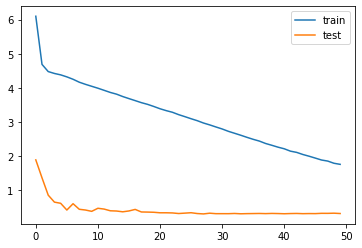

In [37]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [40]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [41]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [42]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [43]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [44]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: simple geometries curves primitive shapes paper presents new approach evaluate muscle contribution anatomically accurate geometries maintaining computational complexity tractable level proposed method muscle structures embedded inside facial continuum mechanical contribution muscles evaluated independently transferred facial computational domain finite element mapping procedure muscle forces decomposed array discrete point loads determined integration points appropriate quadrature scheme result muscle meshes constructed independent facial mesh giving two main advantages muscle geometries refined independent facial computational domain required computational domain conform complex topology muscle structures 
Original summary: 


KeyError: ignored